<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/SIC_Scoring_Sys_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settle in the Cypher (SIC) Dataset Analysis
SIC provided a dataset that contains battle information for 2 different types of scoring systems in this notebook we analyze both scoring systems for similarities

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install factor-analyzer

In [ ]:
pip install semopy

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from factor_analyzer import Rotator
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)
from semopy import Model
from semopy import Optimizer
from semopy.inspector import inspect
from semopy import gather_statistics
import semopy
from semopy import ModelMeans

## Webscraping
It is the dataset provides by SIC, it contains events details, and batle scores

In [ ]:
# Load all sheets into a dictionary of DataFrames
webscraping = pd.read_excel('./datasets/Webscraping.xlsx', sheet_name=None)



/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Events details
Events are collected from 2 different sites, here we load both And8 and WDSF events

In [ ]:
eventsAnd8=webscraping['Events and8'][1:].copy()
new_header= eventsAnd8.iloc[0]
eventsAnd8=eventsAnd8.drop(1)
eventsAnd8.columns = new_header
eventsAnd8.rename(columns={'Name':'Event'}, inplace=True)
eventsAnd8.drop_duplicates(subset=['Event'], inplace=True)

eventsWDSF = webscraping['Events WDSF'][1:].copy()
new_header = eventsWDSF.iloc[0]
eventsWDSF = eventsWDSF.drop(1)
eventsWDSF.columns = new_header
eventsWDSF.rename(columns={'Name': 'Event'}, inplace=True)
eventsWDSF.drop_duplicates(subset=['Event'], inplace=True)

combined_events = pd.concat([eventsAnd8, eventsWDSF], ignore_index=True)


#Threefold
Battles scored using the threefold system

In [ ]:
#threefold battles
threefold = webscraping['Battles and8 Threefold']
threefold.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
threefold[['Event', 'Category']] = threefold[['Event', 'Category']].fillna(method='ffill')
threefold.head(2)

,Event,Category,breaker 1,breaker 2,winner,battle rounds,number of judges,breaker 1 round wins,breaker 2 round wins,breaker 1 vote count,...,r3j7arti,r3j7inte,r3j8over,r3j8phys,r3j8arti,r3j8inte,r3j9over,r3j9phys,r3j9arti,r3j9inte
0,Campionato Italiano di Categoria Breaking FIDS...,1vs1 BBoy 12-15 C Top 16 KnockOut,Baruzzo,Elpablix,Baruzzo,3,3,2,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Campionato Italiano di Categoria Breaking FIDS...,1vs1 BBoy 12-15 C Top 16 KnockOut,Yoga,Faby,Faby,2,3,0,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Trivium Battles
Battles scores using trivium scoring system

In [ ]:
trivium=webscraping['Battles Trivium']
trivium.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
trivium[['Event', 'Category']]= trivium[['Event', 'Category']].fillna(method='ffill')


In [ ]:
trivium_columns=list(trivium.columns)
exclude=['judge 1 name ', 'judge 2 name', 'judge 3 name', 'judge 4 name', 'judge 5 name', 'judge 6 name ', 'judge 7 name', 'judge 8 name', 'judge 9 name'  ]
trivium_columns= [x for x in trivium_columns if x not in exclude]
trivium=trivium[trivium_columns].copy()
trivium['BattleID']= trivium.index

In [ ]:
category_sums_blue = {
    "Creativity": trivium.filter(like="crea").sum(axis=1),
    "Musicality": trivium.filter(like="musi").sum(axis=1),
    "Performance": trivium.filter(like="perf").sum(axis=1),
    "Personality": trivium.filter(like="pers").sum(axis=1),
    "Technique": trivium.filter(like="tech").sum(axis=1),
    "Variety": trivium.filter(like="vari").sum(axis=1),
    "Overall":  trivium.filter(like="over").sum(axis=1)
}

category_sums_red = {
    "Creativity": trivium.filter(like="crea").sum(axis=1)*-1,
    "Musicality": trivium.filter(like="musi").sum(axis=1)*-1,
    "Performance": trivium.filter(like="perf").sum(axis=1)*-1,
    "Personality": trivium.filter(like="pers").sum(axis=1)*-1,
    "Technique": trivium.filter(like="tech").sum(axis=1)*-1,
    "Variety": trivium.filter(like="vari").sum(axis=1)*-1,
    "Overall":  trivium.filter(like="over").sum(axis=1)*-1
}

In [ ]:
scorecardBlue=pd.DataFrame({
    "Event": trivium['Event'],
    'Category': trivium['Category'],
    "BattleID": trivium["BattleID"],
    "Side": "BLUE",
    "Breaker": trivium["breaker 2 (blue)"],
        **category_sums_blue,
})

scorecardRed=pd.DataFrame({
    "Event": trivium['Event'],
    'Category': trivium['Category'],
    "BattleID": trivium["BattleID"],
    "Side": "RED",
    "Breaker": trivium["breaker 1 (red)"],
     **category_sums_red,
})

In [ ]:
scorecard = pd.concat([scorecardBlue, scorecardRed], ignore_index=True)
scorecard['Score Type']="trivium"
scorecard=pd.merge(scorecard, eventsAnd8[['Date', 'Event']], on='Event', how='left')
scorecard.shape

(3052, 14)

Trivium PCA
We perform PCA on battles scored using trivium score system

In [ ]:
triviumScore=scorecardBlue[['Creativity', 'Musicality', 'Performance', 'Personality', 'Technique', 'Variety']]

In [ ]:
#Impute missing values with the mean
names=triviumScore.columns
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
triviumNorm = imputer.fit_transform(triviumScore)
features=imputer.get_feature_names_out(input_features= names)


#normalize float columns
triviumNorm= StandardScaler().fit(triviumNorm).transform(triviumNorm)


In [ ]:
#set PCA
pca = PCA(n_components=3, random_state=0).fit(triviumNorm)
X_pca = pca.transform(triviumNorm)
X_pca.shape, triviumNorm.shape

((1526, 3), (1526, 6))

In [ ]:
loadings_abs = np.abs(pca.components_)
pcs = ['PC1', 'PC2', 'PC3']

# Create DataFrame
pca_loadings = pd.DataFrame(loadings_abs.T, columns=pcs, index=features)



In [ ]:
print( " PCA accum variance: ",np.cumsum(pca.explained_variance_ratio_)[2])

 PCA accum variance:  0.8822364614685656


In [ ]:
pca_loadings.style.background_gradient()

,PC1,PC2,PC3
Creativity,0.362888,0.143561,0.713032
Musicality,0.403575,0.450374,0.269483
Performance,0.469467,0.239068,0.327888
Personality,0.409212,0.452774,0.295638
Technique,0.350112,0.704047,0.190013
Variety,0.441596,0.136793,0.433527


# Exploratory Factor Analysis.
Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. Value of KMO less than 0.6 is considered inadequate.

In [ ]:
kmo_all,kmo_model=calculate_kmo(triviumNorm)
kmo_model

0.6828153227522676

In [ ]:
# perform factor analysis
fa = FactorAnalyzer(3, rotation=None)
fa.fit(triviumNorm)
X_transformed = fa.fit_transform(triviumNorm)

In [ ]:
print( " factor Analysis accum variance: ",fa.get_factor_variance()[2][-1], fa.get_params())

 factor Analysis accum variance:  0.7885636265232234 {'bounds': (0.005, 1), 'impute': 'median', 'is_corr_matrix': False, 'method': 'minres', 'n_factors': 3, 'rotation': None, 'rotation_kwargs': {}, 'svd_method': 'randomized', 'use_smc': True}


In [ ]:
faLoadings=np.abs(fa.loadings_)
fa = ['Factor1', 'Factor2', 'Factor3']

# Create DataFrame
fa_loadings = pd.DataFrame(faLoadings, columns=fa, index=features)

# fa_loadings.T.plot.bar(figsize=(10, 20), subplots=True)


In [ ]:
fa_loadings.style.background_gradient()

,Factor1,Factor2,Factor3
Creativity,0.584749,0.144549,0.356931
Musicality,0.669645,0.352689,0.148181
Performance,0.850926,0.149023,0.278467
Personality,0.728653,0.465250,0.282656
Technique,0.682145,0.707579,0.173523
Variety,0.840725,0.059744,0.537386


In [ ]:
pca_loadings.style.background_gradient()

,PC1,PC2,PC3
Creativity,0.362888,0.143561,0.713032
Musicality,0.403575,0.450374,0.269483
Performance,0.469467,0.239068,0.327888
Personality,0.409212,0.452774,0.295638
Technique,0.350112,0.704047,0.190013
Variety,0.441596,0.136793,0.433527


In [ ]:
normdf = pd.DataFrame(triviumNorm, columns=features)
normdf

,Creativity,Musicality,Performance,Personality,Technique,Variety
0,-1.516892,-0.136318,0.560938,0.313784,2.168559,-1.087127
1,0.104730,0.941751,1.159945,1.219928,1.537056,0.823927
2,-0.986180,-0.407644,0.994701,0.134033,1.989348,1.752689
3,-0.204852,-1.808894,-2.155249,0.202978,-1.040159,-2.638185
4,2.301292,1.279402,-1.318704,-0.110971,-1.620459,1.233439
...,...,...,...,...,...,...
1521,0.709153,0.523306,0.612576,0.514465,0.530065,0.216351
1522,0.576475,-0.313585,0.602249,0.168505,0.231381,-0.140968
1523,1.490480,-0.024170,0.808803,1.334427,-0.118506,0.145423
1524,1.136672,0.859751,0.437005,0.563712,0.350854,0.554934


# Confirmatory Factor Analysis
"In statistics, confirmatory factor analysis (CFA) is a special form of factor analysis, most commonly used in social science research.[1] It is used to test whether measures of a construct are consistent with a researcher's understanding of the nature of that construct (or factor)" more info -->
https://en.wikipedia.org/wiki/Confirmatory_factor_analysis#:~:text=In%20statistics%2C%20confirmatory%20factor%20analysis,that%20construct%20(or%20factor).

We mapped 3 different model to confirm, this models can be read as Physical is a representations of technique plus variate.


*   Model 1 is a representation of the asumption provided by the customer.
*   Model 2 is a representation of PCA,
*   Model 3 is a representation of FA.



In [ ]:
model_spec = '''Physical=~ Technique + Variety
Artistic =~ Creativity + Personality
Interpretive =~ Performance + Musicality
'''

model_spec2='''lv1 =~ Performance + Technique + Variety
lv2 =~ Personality + Musicality + Performance
lv3 =~ Variety + Creativity'''

model_spec3='''lv1 =~ Performance + Variety + Personality
lv2 =~ Technique + Musicality + Personality
lv3 =~ Variety + Creativity'''


We load and fit all three models

In [ ]:
#Model 1 is the current assumptions of representations between observed and latent variables
modelCFA= Model(model_spec)
modelCFA2= Model(model_spec2)
modelCFA3= Model(model_spec3)

modelCFA.fit(normdf)
modelCFA2.fit(normdf)
modelCFA3.fit(normdf)

SolverResult(fun=0.5246412049791003, success=True, n_it=34, x=array([0.52673755, 0.47858368, 0.34501765, 0.74371565, 2.15135246,
       0.        , 0.8380801 , 0.27030823, 0.55217096, 0.70792596,
       0.38359582, 0.72946218, 0.74507471, 0.18799946, 0.29211657,
       0.15956983, 0.21610252]), message='Optimization terminated successfully', name_method='SLSQP', name_obj='MLW')

Inspect all three

In [ ]:
modelCFA.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,Technique,~,Physical,1.000000,-,-,-
1,Variety,~,Physical,0.703333,0.029187,24.097385,0.0
2,Creativity,~,Artistic,1.000000,-,-,-
3,Personality,~,Artistic,2.208731,0.152256,14.506704,0.0
4,Performance,~,Interpretive,1.000000,-,-,-
5,Musicality,~,Interpretive,0.704981,0.024745,28.489786,0.0
6,Artistic,~~,Artistic,0.184216,0.022579,8.158696,0.0
7,Artistic,~~,Interpretive,0.308589,0.025005,12.341045,0.0
8,Artistic,~~,Physical,0.134512,0.014929,9.009963,0.0
9,Interpretive,~~,Interpretive,0.799087,0.038265,20.883249,0.0


In [ ]:
semopy.calc_stats(modelCFA)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,6,15,1526.417852,0.0,5296.640126,0.712131,0.711814,0.279535,0.711814,0.280329,0.407634,27.999452,107.955531,1.000274


Model 2

In [ ]:
modelCFA2.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,Performance,~,lv1,1.000000,-,-,-
1,Performance,~,lv2,0.624815,0.021027,29.715294,0.0
2,Technique,~,lv1,1.694301,0.076312,22.202355,0.0
3,Variety,~,lv1,0.526027,0.038144,13.790674,0.0
4,Variety,~,lv3,1.000000,-,-,-
5,Personality,~,lv2,1.000000,-,-,-
6,Musicality,~,lv2,0.896300,0.026047,34.411051,0.0
7,Creativity,~,lv3,1.074601,0.057676,18.631782,0.0
8,lv1,~~,lv1,0.348445,0.024863,14.014872,0.0
9,lv1,~~,lv2,0.136835,0.015758,8.683372,0.0


In [ ]:
semopy.calc_stats(modelCFA2)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,4,15,72.126723,8.104628e-15,5296.640126,0.987101,0.986383,0.948935,0.986383,0.95163,0.10568,33.90547,124.522358,0.047265


Model 3

In [ ]:
semopy.calc_stats(modelCFA3)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,4,15,800.602479,0.0,5296.640126,0.849175,0.848847,0.433177,0.848847,0.434407,0.361373,32.950718,123.567606,0.524641


In [ ]:
# g = semopy.semplot(modelCFA2, "pd2.png")

In [ ]:
m1=semopy.calc_stats(modelCFA)
m2=semopy.calc_stats(modelCFA2)
m3=semopy.calc_stats(modelCFA3)
m1['Source'] = 'Model 1'
m2['Source'] = 'Model 2'
m3['Source'] = 'Model 3'
models_stacked = pd.concat([m1, m2, m3], axis=0)


In [ ]:
models_stacked[['Source', 'DoF', 'DoF Baseline', 'chi2', 'chi2 p-value', 'chi2 Baseline', 'CFI',
       'GFI', 'AGFI', 'NFI', 'TLI', 'RMSEA', 'AIC', 'BIC', 'LogLik' ]]

,Source,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,Model 1,6,15,1526.417852,0.000000e+00,5296.640126,0.712131,0.711814,0.279535,0.711814,0.280329,0.407634,27.999452,107.955531,1.000274
Value,Model 2,4,15,72.126723,8.104628e-15,5296.640126,0.987101,0.986383,0.948935,0.986383,0.951630,0.105680,33.905470,124.522358,0.047265
Value,Model 3,4,15,800.602479,0.000000e+00,5296.640126,0.849175,0.848847,0.433177,0.848847,0.434407,0.361373,32.950718,123.567606,0.524641


## Model 1

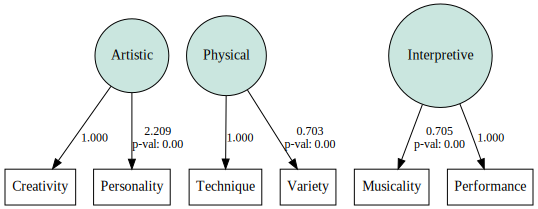

In [ ]:
# @title
# save figure
g = semopy.semplot(modelCFA, "f1.png")
g

## Model 2

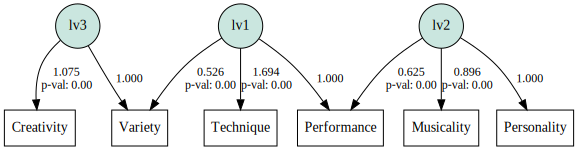

In [ ]:
# @title
# save figure
g = semopy.semplot(modelCFA2, "f2.png")
g

## Model 3

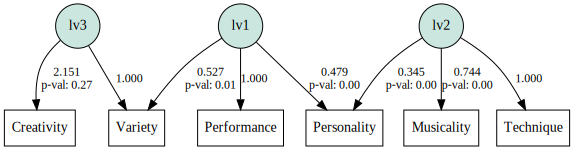

In [ ]:
# @title
# save figure
g = semopy.semplot(modelCFA3, "f3.png")
g

## Results interpretation

Model 1 (Customer Asumptiton) exhibits the poorest fit among the three models, with the highest chi-square value, highest RMSEA, lowest CFI, GFI, AGFI, NFI, and TLI values, and highest AIC and BIC values.

Model 2 (PCA) appears to be the best-fitting model among the three, as it has the lowest chi-square value, lowest RMSEA, highest CFI, GFI, AGFI, NFI, and TLI values, and relatively lower AIC and BIC values compared to the other models.

Model 3 (FA)also shows good fit, but its CFI, GFI, AGFI, NFI, and TLI values are lower than those of Model 2, and its RMSEA value is higher. Its AIC and BIC values are slightly higher than those of Model 2.



In summary, Model 2 demonstrates the best fit, followed by Model 3, while Model 1 shows the worst fit. Model 2 is preferred due to its higher goodness-of-fit indices, lower AIC and BIC values, and lower RMSEA.